In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import pathlib
import glob
import tqdm
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Differentiable preisach model

**Warning**: This is the standard version with B = f(H) and not actually what we need in the end!

In [3]:
import jax
import jax.numpy as jnp
import jax.nn as jnn

import equinox as eqx
import optax

In [4]:
def build_grid(dim, low, high, points_per_dim):
    """Build a uniform grid of points in the given dimension."""
    xs = [jnp.linspace(low, high, points_per_dim) for _ in range(dim)]

    x_g = jnp.meshgrid(*xs)
    x_g = jnp.stack([_x for _x in x_g], axis=-1)
    x_g = x_g.reshape(-1, dim)

    assert x_g.shape[0] == points_per_dim**dim
    return x_g

def filter_function(x):
    return jnn.relu(x[0] - x[1])
    
def filter_grid(x):
    valid_points = jax.vmap(filter_function)(x) == 0
    return x[jnp.where(valid_points == True)]


def build_alpha_beta_grid(points_per_dim):
    return filter_grid(build_grid(2, -1, 1, points_per_dim))

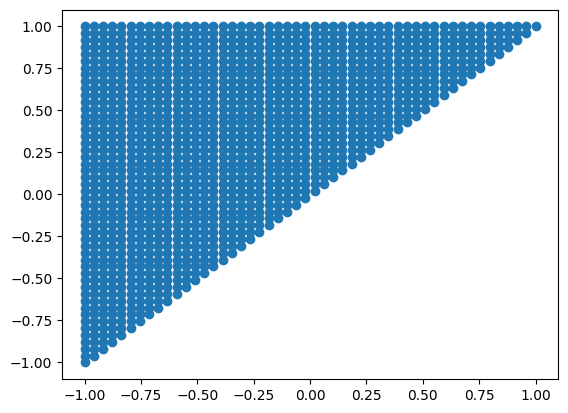

In [5]:
alpha_beta_grid = build_alpha_beta_grid(50)

plt.scatter(alpha_beta_grid[:, 0], alpha_beta_grid[:, 1])

In [ ]:
class HysteronDensity(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=2,
            out_size=1,
            width_size=width_size,
            depth=depth,
            activation=jnn.leaky_relu,
            final_activation=jnn.sigmoid,
            key=key,
        )

    @eqx.filter_jit
    def __call__(self, alpha_beta):
        return self.mlp(alpha_beta)


@eqx.filter_jit
def hysteron_operator(H, initial_field, initial_output, alpha_beta, T):

    alpha = alpha_beta[0]
    beta = alpha_beta[1]

    def true_fun(H, initial_field, initial_output, alpha, beta, T):
        return initial_field
    
    def false_fun(H, initial_field, initial_output, alpha, beta, T):
        def _true_fun(H, initial_output, alpha, beta, T):
            return jax.lax.min(initial_output + (1 + jnp.tanh((H - alpha) / jnp.abs(T))), jnp.array([1.]))
    
        def _false_fun(H, initial_output, alpha, beta, T):
            return jax.lax.max(initial_output - (1 + jnp.tanh(-(H - beta) / jnp.abs(T))), jnp.array([-1.]))

        return jax.lax.cond((H > initial_field)[0], _true_fun, _false_fun, H, initial_output, alpha, beta, T)

    return jax.lax.cond((H == initial_field)[0], true_fun, false_fun, H, initial_field, initial_output, alpha, beta, T)
    

class DifferentiablePreisach(eqx.Module):
    hysteron_density: HysteronDensity

    def __init__(self, width_size, depth, *, model_key, **kwargs):
        super().__init__(**kwargs)
        self.hysteron_density = HysteronDensity(
            width_size=width_size,
            depth=depth,
            key=model_key,
        )

    @eqx.filter_jit
    def __call__(self, H, initial_field, initial_operator_values, alpha_beta_grid, T=1e-2):
        hysteron_density_values = jax.vmap(self.hysteron_density)(alpha_beta_grid)
        hysteron_operator_values = jax.vmap(hysteron_operator, in_axes=(None, None, 0, 0, None))(
            H, initial_field, initial_operator_values, hysteron_density_values, T
        )
        
        return jnp.mean(hysteron_density_values * hysteron_operator_values)[None], hysteron_operator_values

In [ ]:
# Investigate hysteron operator behavior:

outs = []

H = jnp.linspace(-0.3, 0.3, 1000)[..., None]
H = jnp.concatenate([H, jnp.linspace(0.3, -0.3, 1000)[..., None]], axis=0)
H = jnp.concatenate([H, jnp.linspace(-0.3, -0.5, 1000)[..., None]], axis=0)
H = jnp.concatenate([H, jnp.linspace(-0.5, 0.15, 1000)[..., None]], axis=0)
H = jnp.concatenate([H, jnp.linspace(0.15, -0.05, 1000)[..., None]], axis=0)
H = jnp.concatenate([H, jnp.linspace(-0.05, 0.1, 1000)[..., None]], axis=0)

# H = jnp.linspace(-0.3, 0.3, 1000)[..., None]
# H = jnp.concatenate([H, jnp.linspace(0.29, -0.1, 1000)[..., None]], axis=0)

positive_direction = True

initial_output = jnp.array([-1.])
initial_field = jnp.array([-10.1])
H_last = initial_field  # only used for sign change detection

for idx, H_in in enumerate(H):
    
    if positive_direction:
        if H_in < H_last:
            # print("Sign change detected")
            # print(H_in)
            # print(H_last)
            # print(output)
            initial_output = output
            initial_field = H_last
            positive_direction = False
    else:
        if H_in > H_last:
            # print("Sign change detected")
            # print(H_in)
            # print(H_last)
            # print(output)
            initial_output = output
            initial_field = H_last
            positive_direction = True


    # if idx >= 1000:
    #     print("H_in", H_in)
    #     print("H_last", H_last)
    #     print("positive_direction", positive_direction)

    #     print("initial_field", initial_field)
    #     print("initial_output", initial_output)

    #     print(" ")
        

    output = hysteron_operator(
        H_in,
        initial_field,
        initial_output,
        jnp.array([0.2, -0.15]),
        1e-1,
    )
    H_last = H_in

    outs.append(output)

plt.plot(H, outs)
plt.grid()
plt.show()

plt.plot(H)
plt.plot(outs)

In [ ]:
alpha_beta_grid = build_alpha_beta_grid(50)
model = DifferentiablePreisach(
    width_size=128, 
    depth=3,
    model_key=jax.random.PRNGKey(0)
)

In [ ]:
# Investigate hysteron operator behavior:

B_traj = []

H = jnp.linspace(-5, 5, 10_000)[..., None]
H = jnp.concatenate([H, jnp.linspace(5, -2, 10_000)[..., None]], axis=0)

# H = jnp.linspace(-0.3, 0.3, 10_000)[..., None]
# H = jnp.concatenate([H, jnp.linspace(0.3, -0.3, 1000)[..., None]], axis=0)
# H = jnp.concatenate([H, jnp.linspace(-0.3, -0.5, 1000)[..., None]], axis=0)
# H = jnp.concatenate([H, jnp.linspace(-0.5, 0.15, 1000)[..., None]], axis=0)
# H = jnp.concatenate([H, jnp.linspace(0.15, -0.05, 1000)[..., None]], axis=0)
# H = jnp.concatenate([H, jnp.linspace(-0.05, 0.1, 1000)[..., None]], axis=0)

# H = jnp.linspace(-0.3, 0.3, 1000)[..., None]
# H = jnp.concatenate([H, jnp.linspace(0.29, -0.1, 1000)[..., None]], axis=0)

positive_direction = True

initial_operator_values = - jnp.ones((alpha_beta_grid.shape[0], 1))
initial_field = jnp.array([-10.1])
H_last = initial_field  # only used for sign change detection

for idx, H_in in enumerate(H):
    
    if positive_direction:
        if H_in < H_last:
            initial_operator_values = operator_values
            initial_field = H_last
            positive_direction = False
    else:
        if H_in > H_last:
            initial_operator_values = operator_values
            initial_field = H_last
            positive_direction = True
       

    B, operator_values = model(
        H=H_in,
        initial_field=initial_field,
        initial_operator_values=initial_operator_values,
        alpha_beta_grid=alpha_beta_grid,
        T=1
    )
    H_last = H_in

    B_traj.append(B)

plt.plot(H, B_traj)
plt.grid()
plt.show()

plt.plot(H, B_traj)
plt.grid()
plt.xlim(-0.1, 0.1)
plt.xlim(-0.4, -0.2)
plt.show()

plt.plot(H)
plt.grid()
plt.plot(B_traj)

In [ ]:
def update_state(H, carry):

    def true_fun(H, carry):
        # case that we are going in a positive direction

        def _true_fun(carry):
            # positive direction and sign change -> update initial states
            positive_direction, initial_field, last_H, initial_operator_values, last_operator_values = carry
            initial_operator_values = last_operator_values
            intitial_field = last_H
            positive_direction = jnp.array([False])
            return positive_direction, initial_field, initial_operator_values
    
        def _false_fun(carry):
            # positive direction and no sign change -> return values as they are
            positive_direction, initial_field, last_H, initial_operator_values, last_operator_values = carry
            return positive_direction, initial_field, initial_operator_values

        last_H = carry[2]
        return jax.lax.cond((H < last_H)[0], _true_fun, _false_fun, carry)
    
    def false_fun(H, carry):
        def _true_fun(carry):
            # negative direction and sign change -> update initial states
            positive_direction, initial_field, last_H, initial_operator_values, last_operator_values = carry
            initial_operator_values = last_operator_values
            intitial_field = last_H
            positive_direction = jnp.array([True])
            
            return positive_direction, initial_field, initial_operator_values
    
        def _false_fun(carry):
            # negative direction and no sign change -> return values as they are
            positive_direction, initial_field, last_H, initial_operator_values, last_operator_values = carry
            return positive_direction, initial_field, initial_operator_values

        last_H = carry[2]
        return jax.lax.cond((H > last_H)[0], _true_fun, _false_fun, carry)

    positive_direction = carry[0]
    return jax.lax.cond(positive_direction[0], true_fun, false_fun, H, carry)


def estimate_B(H_trajectory, model, alpha_beta_grid):
    initial_field = jnp.array([-10.1])
    last_H = deepcopy(initial_field)

    initial_operator_values = -jnp.ones((alpha_beta_grid.shape[0], 1))
    last_operator_values = deepcopy(initial_operator_values)

    positive_direction = H_trajectory[0] > initial_field

    def body(carry, H):
        positive_direction, initial_field, last_H, initial_operator_values, last_operator_values = carry

        # update initial_field and initial_operator_values based on sign change
        positive_direction, initial_field, initial_operator_values = update_state(H, carry)

        B_est_single, operator_values = model(
            H=H,
            initial_field=initial_field,
            initial_operator_values=initial_operator_values,
            alpha_beta_grid=alpha_beta_grid,
            T=1
        )

        last_H = H
        last_operator_values = operator_values

        return (positive_direction, initial_field, last_H, initial_operator_values, last_operator_values), B_est_single

    _, B_est =  jax.lax.scan(
        body,
        (positive_direction, initial_field, last_H, initial_operator_values, last_operator_values),
        H_trajectory
    )
    return B_est

    
B_est = estimate_B(H, model, alpha_beta_grid)

plt.plot(H)
plt.grid()
plt.show()

plt.plot(H, B_est)
plt.grid()
plt.show()

plt.plot(H)
plt.grid()
plt.plot(B_est)

In [ ]:
from mc2.data_management import FrequencySet, MaterialSet, DataSet

In [ ]:
dataset = DataSet.load_from_file(pathlib.Path("../../data/processed") / "ten_mat_data.pickle")

In [ ]:
B_trajectory = dataset[0][0].B[0, :1000][..., None]
H_trajectory = dataset[0][0].H[0, :1000][..., None] / 100

In [ ]:
signs = jnp.sign(jnp.roll(H_trajectory, shift=1) - H_trajectory)
signs

plt.plot(signs)

# sign_changes = jnp.diff(signs, n=1, axis=0)
# sign_changes

In [ ]:
plt.plot(H_trajectory)
plt.plot(B_est)

In [ ]:
# def estimate_B(H_trajectory, model, alpha_beta_grid):
#     last_H = jnp.array([0.0])
#     last_hysteron_operator_values=jnp.ones((alpha_beta_grid.shape[0], 1))

#     def body(carry, H):
#         last_H, last_hysteron_operator_values = carry
#         B_est_single, hysteron_operator_values = model(
#             H, last_H, last_hysteron_operator_values, alpha_beta_grid
#         )
#         return (H, hysteron_operator_values), B_est_single

#     _, B_est =  jax.lax.scan(body, (last_H, last_hysteron_operator_values), H_trajectory)
#     return B_est

    
# B_est = estimate_B(H_trajectory, model, alpha_beta_grid)

In [ ]:
@eqx.filter_jit
@eqx.filter_value_and_grad
def compute_loss_and_grad(model, H_trajectory, B_trajectory, alpha_beta_grid):
    B_est = estimate_B(H_trajectory, model, alpha_beta_grid)

    return jnp.mean((B_est - B_trajectory)**2)

In [ ]:
alpha_beta_grid = build_alpha_beta_grid(100)

model = DifferentiablePreisach(
    width_size=128, 
    depth=3,
    model_key=jax.random.PRNGKey(0)
)
optim = optax.adam(learning_rate=1e-2)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

# jax.vmap(model.hysteron_density)(alpha_beta_grid).reshape(20,20)

# plt.show()

B_est = estimate_B(H_trajectory, model, alpha_beta_grid)

plt.plot(B_trajectory)
plt.plot(B_est)
plt.show()

plt.plot(H_trajectory, B_trajectory)
plt.show()


plt.plot(H_trajectory, B_est)
plt.show()

In [ ]:
for n in tqdm.tqdm(range(100)):

    loss, grads = compute_loss_and_grad(model, H_trajectory, B_trajectory, alpha_beta_grid)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    # if n % 10 == 0:
    #     print(loss)

In [ ]:
B_est = estimate_B(H_trajectory, model, alpha_beta_grid)

plt.plot(B_trajectory)
plt.plot(B_est)
plt.show()

plt.plot(H_trajectory, B_trajectory)
plt.show()


plt.plot(H_trajectory, B_est)
plt.show()